## Punto 2 - Primera parte
### Almacenamiento de los datos


In [1]:
import pandas as pd
sales = pd.read_excel('Datos_segundo_punto_17Co2024_Grupo4.xlsx')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
sales["DiaDeSemana"] = sales["Fecha"].dt.weekday
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Fecha        365 non-null    datetime64[ns]
 1   Ventas       365 non-null    float64       
 2   Mes          365 non-null    int32         
 3   DiaDeSemana  365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 8.7 KB


In [2]:
sales.head()

,Fecha,Ventas,Mes,DiaDeSemana
0,2023-01-01,14864.134184,1,6
1,2023-01-02,16853.696596,1,0
2,2023-01-03,20726.932468,1,1
3,2023-01-04,19102.646430,1,2
4,2023-01-05,18955.206970,1,3


In [3]:
sales.tail()

,Fecha,Ventas,Mes,DiaDeSemana
360,2023-12-27,24173.447572,12,2
361,2023-12-28,22654.251064,12,3
362,2023-12-29,22822.365415,12,4
363,2023-12-30,19059.956125,12,5
364,2023-12-31,17446.387915,12,6


## a) ¿Cómo se comportan las ventas mes a mes?

In [4]:
import matplotlib.pyplot as plt
import math
def plot_sales(data, plot_fun,title, n = 3, pad = 2.0):
    m = math.ceil(len(data)/n)
    figure, axis = plt.subplots(m,n, figsize=(10,10))
    figure.tight_layout(pad = pad)
    for i in range(m*n):
        row = i//n
        col = i%n
        if i < len(data):
            axis[row][col].set_title(f"{title}: {i+1}")
            plot_fun(data[i], axis[row][col])
        else: 
            axis[row][col].axis('off')

In [5]:
sales_per_month = [sales[sales["Mes"] == (i+1)]["Ventas"].values for i in range(12)]

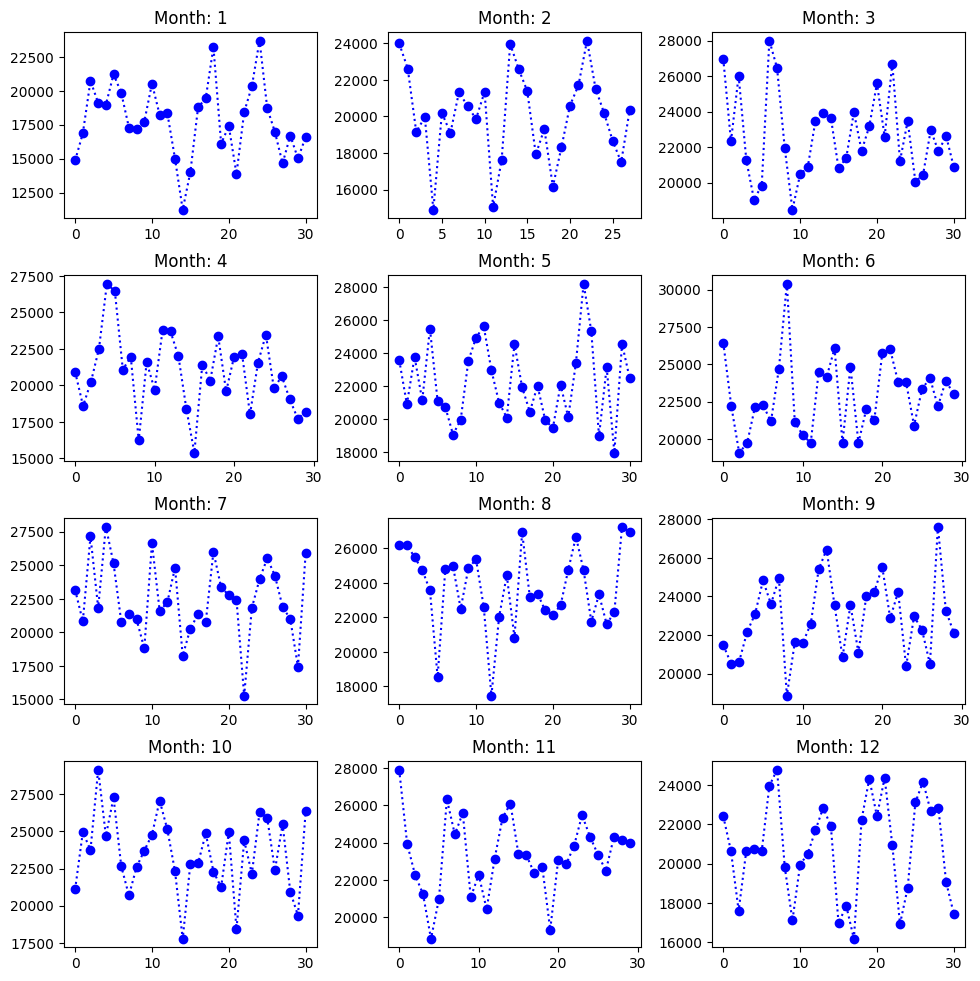

In [6]:
def month_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')
plot_sales(sales_per_month,  month_sale_plot_fun , title='Month')

## b) ¿Cómo se comportan las ventas en cada día de la semana?

In [7]:
sales_per_weekday = [sales[sales["DiaDeSemana"] == i]["Ventas"].values for i in range(7)]

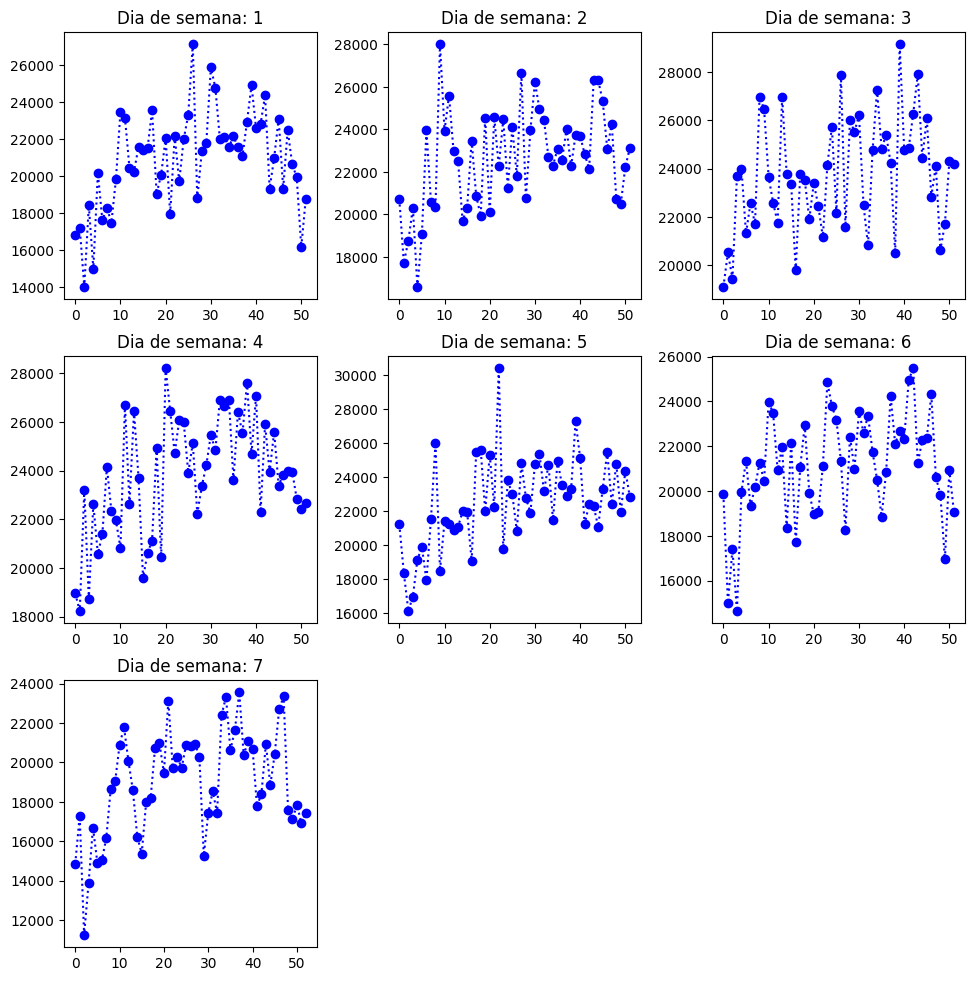

In [8]:
def weekday_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')        

plot_sales(sales_per_weekday,  weekday_sale_plot_fun , title='Dia de semana')

Donde dia 0 corresponde a Lunes, y 6 a Domingo.

## Punto 2 - Segunda Parte

In [9]:
# --- Turning off warnings for grid search
import warnings
warnings.filterwarnings("ignore")
# ----

import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def plot_estimations(X, ax):
    # assume X is 1-Dimensional, X is the data array
    ecdf = ECDF(X)    
    
    # Validación cruzada para identificar kernel y bandwidth
    # ==============================================================================
    
    param_grid = {
        'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear', 'cosine', 'tophat'],
        'bandwidth' : np.linspace(start=0.1, stop=10000, num=1000)
    }
    
    grid = GridSearchCV(
            estimator  = KernelDensity(),
            param_grid = param_grid,
            n_jobs     = -1,
            cv         = 10, 
            verbose    = 0
          )
    
    # Se asigna el resultado a _ para que no se imprima por pantalla
    _ = grid.fit(X = X.reshape(-1,1))
    # .reshape(-1.1) => [[x1], [x2], ...] 
    
    
    # Mejores hiperparámetros por validación cruzada
    # ==============================================================================
    # print("----------------------------------------")
    # print("Mejores hiperparámetros encontrados (cv)")
    # print("----------------------------------------")
    # print(grid.best_params_, ":", grid.best_score_, grid.scoring)
    
    modelo_kde_final = grid.best_estimator_
    
    
    # Gráficos distribución de densidad modelo final
    # ==============================================================================
    X_grid = np.linspace(start=min(X), stop=max(X), num=100)
    log_density_pred = modelo_kde_final.score_samples(X_grid.reshape(-1,1))
    density_pred = np.exp(log_density_pred)
    # 
    # fig, ax = plt.subplots(figsize=(7,4))
    density, bins, patches = ax.hist(X, bins=100, density=True)
    
    ax.plot(X_grid, density_pred, color = 'red', label=f'Kernel: {grid.best_params_["kernel"]} \n bw: {"{0:.3f}".format(grid.best_params_["bandwidth"])}')
    ax.plot(X.flatten(), np.full_like(X.flatten(), -0.00001), '|k', markeredgewidth=1)
    ax.set_xlabel('x')
    ax.set_ylabel('densidad')
    ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(ecdf.x, ecdf.y, marker='o', linestyle=':', color='orange', label='ECDF')
    ax2.legend(loc=4)

## a)  Funciones empı́ricas de distribución y aproximaciones a las funciones de densidad para dichas distribuciones, para las ventas durante cada uno de los meses del año.

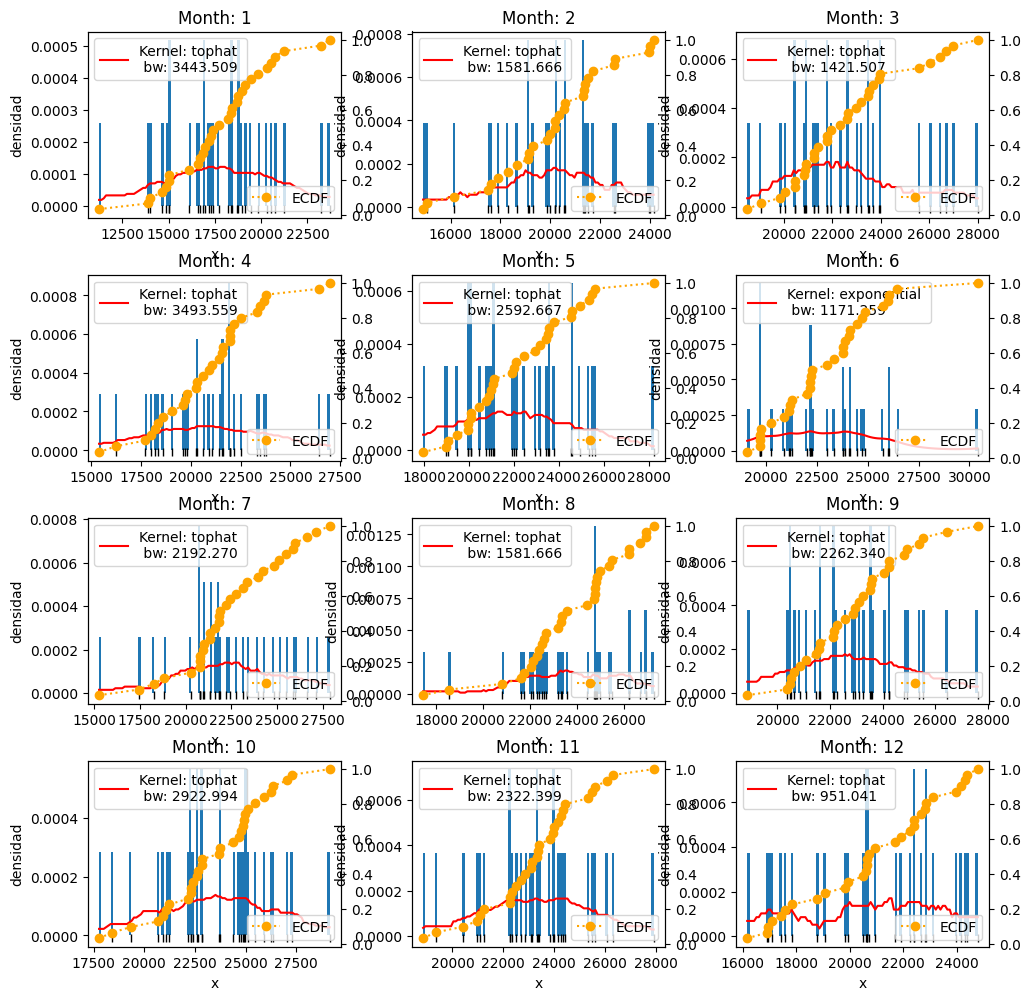

In [10]:
def month_estimation_plot_fun(data, ax):    
    plot_estimations(data, ax)
plot_sales(sales_per_month, month_estimation_plot_fun , title='Month')

## b) Funciones empı́ricas de distribución y aproximaciones a las funciones de densidad para dichas distribuciones, para las ventas por cada dı́a de la semana.

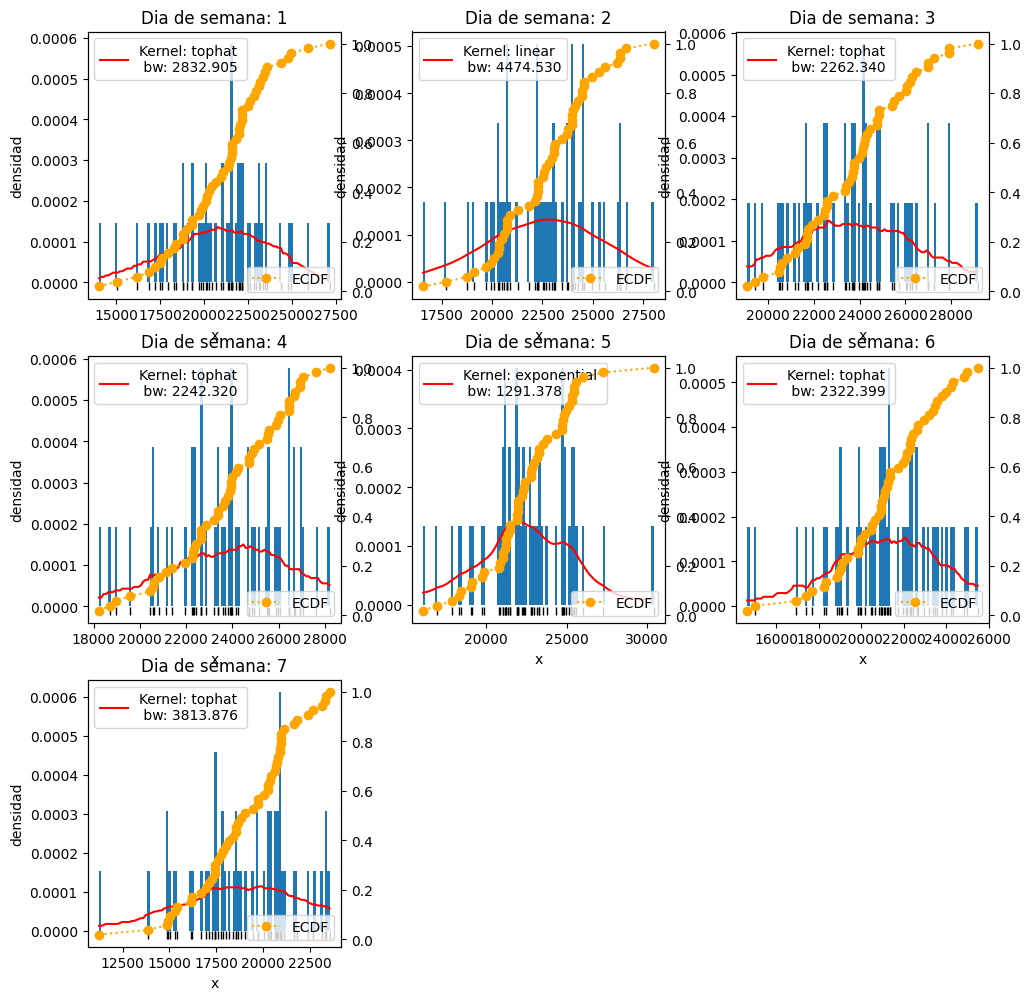

In [11]:
def weekday_estimation_plot_fun(data, ax):    
    plot_estimations(data, ax)
plot_sales(sales_per_weekday,  weekday_estimation_plot_fun , title='Dia de semana')